In [1]:
! pip install pandas

In [2]:
import os

# GLobal Constants

In [3]:
DATASET_DIR = f"..{os.sep}dataset{os.sep}IIIT-CFW1.0"
CARTOON_DATASET = "cartoonFaces"
REAL_FACES = "realFaces"
DATASET_FILE = "dataset.csv"

RANDOM_STATE = 1

# Load the Dataset

In [4]:
import pandas as pd

dataset = pd.read_csv(f"{DATASET_DIR}/{DATASET_FILE}")
dataset.tail()

,file,is_real
9923,../dataset/IIIT-CFW1.0/cartoonFaces/AlbertEins...,0.0
9924,../dataset/IIIT-CFW1.0/cartoonFaces/NelsonMand...,0.0
9925,../dataset/IIIT-CFW1.0/cartoonFaces/Beyonce004...,0.0
9926,../dataset/IIIT-CFW1.0/cartoonFaces/SylvesterS...,0.0
9927,../dataset/IIIT-CFW1.0/cartoonFaces/DavidBeckh...,0.0


# Build Dataset

In [5]:
%%writefile ../src/dataset.py
from torch.utils.data import Dataset
from torch import is_tensor, Tensor
from PIL import Image
from pandas import concat, read_csv
import os

class RealCartoon(Dataset):
    """This is a dataset class to load the real and fake dataset with bool labels. 
    """

    def __init__(self, csv_file:str, set_type:str, root_dir:str="./", transforms=None, random_state:int=1) -> None:
        super().__init__()
        self.root_dir = root_dir

        # identify the type of dataset
        self.set_type = set_type
        assert self.set_type in ['train', 'test', 'val'], f"Invalid set type!!!"

        # load the dataset
        self.csv_file = csv_file
        self.dataset = read_csv(csv_file)
        # split into real and cartoon
        real_df = self.dataset[self.dataset.is_real == 1].sample(random_state=random_state,frac=1)
        fake_df = self.dataset[self.dataset.is_real == 0].sample(random_state=random_state, frac=1)
        # get test, train, val dataset
        train_size = int(len(real_df)*0.8)
        test_size = int(len(real_df)*0.1)
        real_df = real_df[:train_size] if self.set_type == 'train' else real_df[train_size:train_size+test_size] if self.set_type == 'test' else real_df[train_size+test_size:]
        train_size = int(len(fake_df)*0.8)
        test_size = int(len(fake_df)*0.1)
        fake_df = fake_df[:train_size] if self.set_type == 'train' else fake_df[train_size:train_size+test_size] if self.set_type == 'test' else fake_df[train_size+test_size:]
        # combine the datasets
        self.dataset = concat([real_df,fake_df], axis=0)
        # randomly sample the dataset
        self.dataset = self.dataset.sample(random_state=random_state, frac=1, ignore_index=True)
        # load transforms
        self.transforms = transforms


    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])
        image = Image.open(img_name)
        if image.mode == "L":
            img_name = os.path.join(self.root_dir, self.dataset.iloc[1, 0])
            image = Image.open(img_name)

        label = Tensor([self.dataset.iloc[idx, -1]])

        if self.transforms:
            image = self.transforms(image)

        return (image, label)

Overwriting ../src/dataset.py


In [6]:
from torchvision import transforms
import os, sys

root_dir = os.path.abspath(os.path.join('..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from src.dataset import RealCartoon

image_dataset = RealCartoon(
    csv_file=f"{DATASET_DIR}/{DATASET_FILE}",
    set_type='train',
    root_dir='./',
    transforms=transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=(0.6,1), contrast=(0.6,1)),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
image_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

# Plot Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


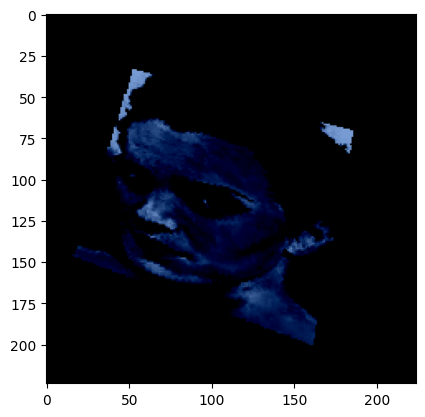

In [7]:
import random
import matplotlib.pyplot as plt

image_index = random.randint(0,len(image_dataset))

plt.imshow(image_dataset[image_index][0].permute(1, 2, 0)  )


In [8]:
# for image, lable in image_dataset:
#     print(image.shape)